The goal of this project is to model a wind turbine basing on available NASA meteorological data for selected location. The Surface type ("Crop: 20-m broadleaf-deciduous trees (10%) & wheat"), evelevation for the corrected wind speed (20 m), hub height (100 m) and turbine type have been chosen arbitrarily. <br>
The wind turbine modeling section will include correcting the wind speed by the angle between wind and rotor's direction. Not including the angle results in an assumption that the wind always moves directly towards the turbine which is unrealistic in practice.
<ol>Steps:
    <li>Libraries import and parameter configuration</li>
    <li>Meteorological preparation for modeling</li>
    <ul>
        <li>Meteorological data loading and preprocessing</li>
        <li>Roughness length calculation</li>
        <li>Data overwiew</li>
        <li>Meteorological data processing</li>
    </ul>
    <li>Wind turbine modeling</li>
    <ul>
        <li>Wind turbine model preparation</li>
        <li>Correcting the model by yaw misalignment</li>
        <ul>
            <li>Turbine with fixed direction</li>
            <li>Fully rotatable nacelle with fixed yaw misalignment angle</li>
        </ul>
        <li>Results analysis</li>
        <li>Saving final dataset</li>
    </ul>
</ol>

# 1. Libraries import and parameter configuration

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from windpowerlib import ModelChain, WindTurbine
from windpowerlib import data as wt

#print options have been set to display only values instead of data format with values in parenthesis. 
np.set_printoptions(legacy='1.25')

# 2. Meteorological data preparation

## 2.1. Meteorological data loading and preprocessing

In [2]:
os.listdir()

['.ipynb_checkpoints',
 '1_wind_speed_distribution_fitting.ipynb',
 '2_wind_turbine_modeling.ipynb',
 'POWER_Point_Hourly_20230801_20250731_052d37N_017d62E_UTC.csv']

In [3]:
weather_df = pd.read_csv('POWER_Point_Hourly_20230801_20250731_052d37N_017d62E_UTC.csv', skiprows=list(range(15)),header=[0])
weather_df.set_index(pd.date_range(start='2023-08-01 00:00', end='2025-07-31 23:00', freq='1h'), inplace=True)
#weather_df = weather_df[['WS50M', 'T2M', 'PS']]
weather_df.head()

,YEAR,MO,DY,HR,WS50M,WD50M,T2M,PS,WSC
2023-08-01 00:00:00,2023,8,1,0,7.80,189.5,17.10,99.26,5.82
2023-08-01 01:00:00,2023,8,1,1,7.43,189.0,16.86,99.19,5.54
2023-08-01 02:00:00,2023,8,1,2,7.28,184.7,16.68,99.10,5.43
2023-08-01 03:00:00,2023,8,1,3,7.59,186.9,16.56,99.04,5.66
2023-08-01 04:00:00,2023,8,1,4,7.03,188.1,16.72,98.99,5.24


In [4]:
weather_df = weather_df.iloc[:, 4:]
weather_df.sample()

,WS50M,WD50M,T2M,PS,WSC
2023-08-27 23:00:00,5.68,292.7,17.48,99.63,4.24


The weather_df dataframe is ready for the further data preparation. The current columns are:
<ul>
    <li>WS50M - wind speed at 50 m [m/s]</li>
    <li>WD50M - wind direction at 50 m [°]</li>
    <li>T2M - temperature at 2 m [°C]</li>
    <li>PS - surface pressure [kPa]</li>
    <li>WSC - corrected wind speed value for the selected elevation (20 m) [m/s]</li>
</ul>


## 2.2. Roughness length calculation

According to the <a href=https://power.larc.nasa.gov/docs/methodology/meteorology/wind/>NASA documentation</a>, the corrected wind speed value (WSC) is calculated basing on the wind speed at 50 m. The formula below already includes the selected elevation (20 m): <br>
$$
WSC_{20m} = WS_{50m} \times (\frac{20}{50})^{\alpha}
$$
Using the above equation, roughness length formula is:
$$
\alpha = \frac{log(\frac{WSC_{20m}}{WS_{50m}})}{log(\frac{20}{50})}
$$

In [5]:
weather_df['Roughness_length'] = np.log(weather_df['WSC']/weather_df['WS50M']) / np.log(20/50)
weather_df['Roughness_length'].describe()

count    17544.000000
mean         0.319997
std          0.001440
min          0.274274
25%          0.319427
50%          0.320002
75%          0.320566
max          0.389260
Name: Roughness_length, dtype: float64

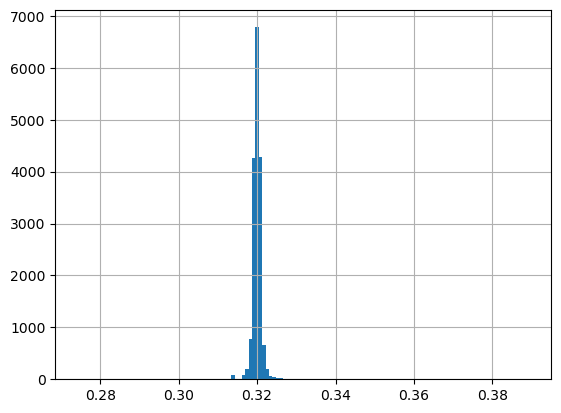

In [6]:
weather_df['Roughness_length'].hist(bins=int(np.round(len(weather_df)**0.5, 0)));

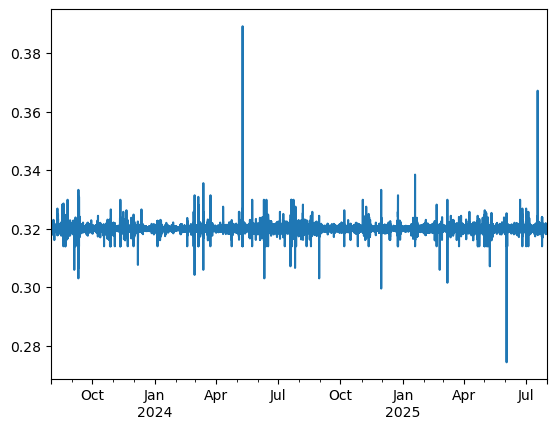

In [7]:
weather_df['Roughness_length'].plot();

In [8]:
weather_df['Roughness_length'] = weather_df['Roughness_length'].mode()[0]
weather_df.sample(5)

,WS50M,WD50M,T2M,PS,WSC,Roughness_length
2025-07-04 00:00:00,5.15,328.8,12.92,101.21,3.84,0.320147
2024-01-09 12:00:00,2.06,231.9,-6.63,102.48,1.54,0.320147
2023-10-30 00:00:00,10.16,223.4,11.99,99.17,7.58,0.320147
2024-07-14 15:00:00,3.84,167.2,24.45,100.25,2.86,0.320147
2024-09-16 04:00:00,6.99,34.4,14.81,100.31,5.21,0.320147


The roughness length is not constant for the meteorological data. According to the time series plot there should be no noticeable seasonality by seasons or months. <br>
Although using such vector of non-identical roughness lengths may still be reasonable, it has been decided to use a value which make this factor uniform for the entire time series. The mode has been chosen because the data already concentrates in the relatively narrow range of values (according to the histogram) and, unlike to the mean, mode is less vulnerable to any potential outliers/extreme values.

## 2.3. Data overview

In [9]:
#roughness_length was exceluded because it is constant
weather_df.iloc[:, :-1].describe()

,WS50M,WD50M,T2M,PS,WSC
count,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000
mean,6.537983,203.189888,10.579221,100.263727,4.876442
std,2.923667,86.388012,8.736366,0.961739,2.180644
min,0.090000,0.000000,-13.490000,96.350000,0.070000
25%,4.500000,141.600000,3.380000,99.690000,3.360000
50%,6.380000,217.400000,10.295000,100.280000,4.760000
75%,8.250000,271.500000,17.610000,100.900000,6.150000
max,19.370000,359.900000,32.810000,102.870000,14.450000


In [10]:
dispersion_df = weather_df.describe().iloc[[1, 2],:-1].T
dispersion_df['CV'] = dispersion_df['std'] / dispersion_df['mean']
dispersion_df

,mean,std,CV
WS50M,6.537983,2.923667,0.447182
WD50M,203.189888,86.388012,0.425159
T2M,10.579221,8.736366,0.825804
PS,100.263727,0.961739,0.009592
WSC,4.876442,2.180644,0.447179


Temperature is the most volatile value but taking into account seasons this should not be surprising. It can be noticed only ~20% of wind speed range is between 25th and 75th percentiles. Surface pressure remains very stable.

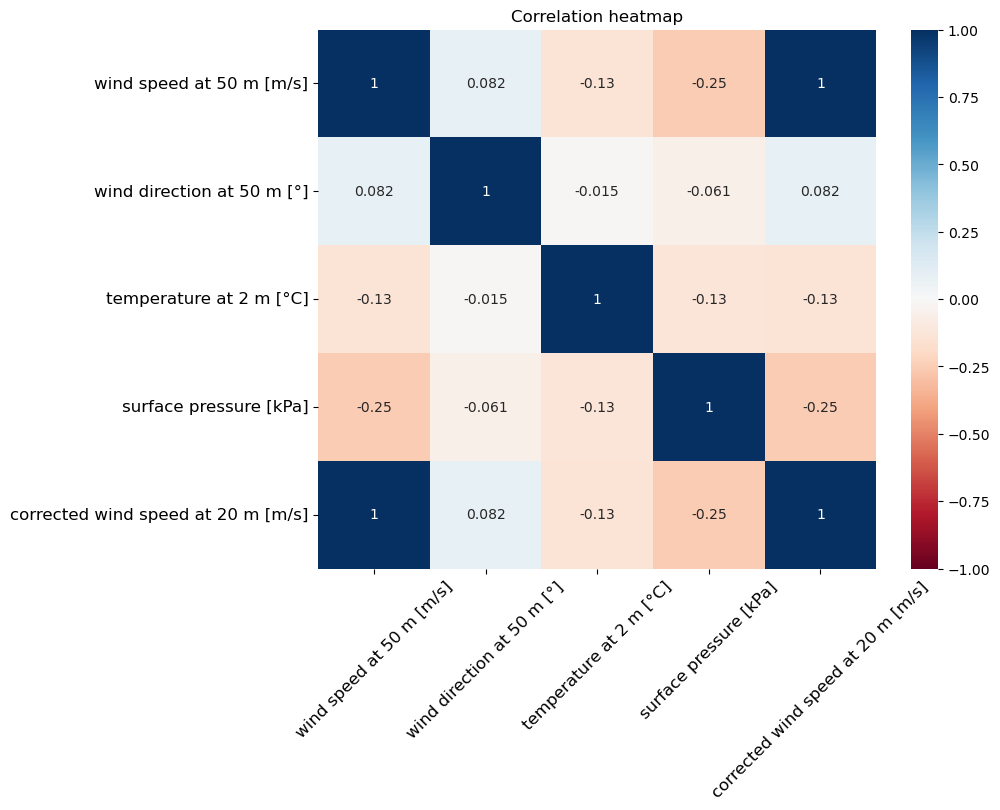

In [11]:
temp_col_names = {
    'WS50M': 'wind speed at 50 m [m/s]', 
    'WD50M': 'wind direction at 50 m [°]', 
    'T2M': 'temperature at 2 m [°C]', 
    'PS': 'surface pressure [kPa]', 
    'WSC': 'corrected wind speed at 20 m [m/s]'
}
plt.figure(figsize=(9, 7))
s = sns.heatmap(weather_df.rename(columns=temp_col_names).iloc[:, :-1].corr('spearman'), annot=True, cmap='RdBu', vmin=-1, vmax=1)
s.set_yticklabels(s.get_yticklabels(), rotation=0, fontsize=12)
s.set_xticklabels(s.get_xticklabels(), rotation=45, fontsize=12)
plt.title('Correlation heatmap')
plt.show()

The Spearman correlation coefficent has been used because it checks both linear and non-linear relationships while Pearson checks only the linear one. <br>
Correlation value for "wind speed at 50 m [m/s]"-"corrected wind speed at 20 m [m/s]" equals 1 because, as it was explained in the the "Roughness length calculation" section, corrected wind speed value is calculated basing on the wind speed at 50 m. <br>
Correlations between "wind direction at 50 m [°]" and other vectors may be called weak (|coefficient| < 0,1). Remaining correlations can be defined as moderate. Results may have been different if all the data refered to the same height.

## 2.4. Meteorological data processing

The final weather dataframe has been prepared below. Windpowerlib library requires multiindex type of columns with the "(column name, reference height)" structure.

In [12]:
weather_df['T2M'] = weather_df['T2M'] + 273.3  # changing temeprature unit from Celsius to Kelvin
weather_df['PS'] = weather_df['PS'] * 1000  # changing pressure unit from kPa to Pa
final_weather_df = weather_df[['WS50M', 'T2M', 'PS', 'Roughness_length']].copy()
final_weather_df.columns = pd.MultiIndex.from_tuples([('wind_speed', 50), ('temperature', 2), ('pressure', 0), ('roughness_length', 0)])  # chanigng columns to MultiIndex to meet windpowerlib library's requirement
final_weather_df.sample(5)

,wind_speed,temperature,pressure,roughness_length
,50,2,0,0
2023-08-11 01:00:00,2.93,286.21,100910.0,0.320147
2024-05-13 08:00:00,3.36,290.66,100980.0,0.320147
2023-10-15 22:00:00,10.77,280.19,100210.0,0.320147
2024-12-08 08:00:00,5.73,274.12,99920.0,0.320147
2024-06-24 15:00:00,3.11,296.45,100670.0,0.320147


# 3. Wind turbine modeling

## 3.1. Wind turbine model preparation

This section focuses on selecting turbine type, preparing raw turbine model and executing a test. The only criteria of choosing a turbine type is having both power and power coefficient curves to make sure these technical properties are included in the model.

In [13]:
turbine_list = wt.get_turbine_types(print_out=False)
turbine_list.sample(5)

C:\ProgramData\anaconda3\Lib\site-packages\windpowerlib\data.py:103: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(False)


,manufacturer,turbine_type,has_power_curve,has_cp_curve
33,Senvion/REpower,MM92/2050,True,False
46,Siemens,SWT142/3150,True,True
65,Vestas,V90/3000,True,False
43,Siemens,SWT120/3600,True,True
49,Vestas,V100/1800/GS,True,True


In [14]:
# has_cp_curve = has power coefficient curve
turbine_list[(turbine_list['has_power_curve'] == True) & (turbine_list['has_cp_curve'] == True)]

,manufacturer,turbine_type,has_power_curve,has_cp_curve
1,Enercon,E-101/3050,True,True
2,Enercon,E-101/3500,True,True
3,Enercon,E-115/3000,True,True
4,Enercon,E-115/3200,True,True
5,Enercon,E-126/4200,True,True
8,Enercon,E-141/4200,True,True
9,Enercon,E-53/800,True,True
11,Enercon,E-70/2300,True,True
12,Enercon,E-82/2000,True,True
13,Enercon,E-82/2300,True,True


In [15]:
wind_turbine_type = WindTurbine(turbine_type = 'V112/3000', hub_height=100)
print(wind_turbine_type)

turbine_sub_model = {
    'wind_speed_model': 'hellman',  #'hellman', 'logarithmic' (default), 'interpolation-extrapolation'
    'density_model': 'barometric',  # 'barometric' (default), 'ideal_gas', 'interpolation-extrapolation'
    'temperature_model':  'linear_gradient',  # 'linear_gradient', 'interpolation-extrapolation'
    'power_output_model': 'power_coefficient_curve',  # 'power_curve' (default), 'power_coefficient_curve'
    'density_correction': True,  # False (default), True
    'hellman_exp': 0.25  # alpha in Hellman speed model
}

turbine_model = ModelChain(wind_turbine_type, **turbine_sub_model).run_model(final_weather_df)
turbine_power_output = turbine_model.power_output / 10**6  # Changing units from W to MW

Wind turbine: V112/3000 ['nominal power=3000000.0 W', 'hub height=100 m', 'rotor diameter=112.0 m', 'power_coefficient_curve=True', 'power_curve=True']


In [16]:
print(
    f'Total 2-year production [MWh]: {(turbine_power_output).sum()}',
    f'Average production [MWh/year]: {(turbine_power_output).sum() /2}', 
    f'Average production [MWh/MW/year]: {(turbine_power_output).sum() /2 / (wind_turbine_type.nominal_power / 10**6)}', 
    sep='\n'
)

Total 2-year production [MWh]: 24372.40537184711
Average production [MWh/year]: 12186.202685923556
Average production [MWh/MW/year]: 4062.0675619745184


In [17]:
model_df = pd.DataFrame(data={'Power [MW]': turbine_power_output, 'wind speed': final_weather_df[('wind_speed', 50)]})
rolling_model_df = model_df.rolling(365*24)['Power [MW]'].sum().dropna()

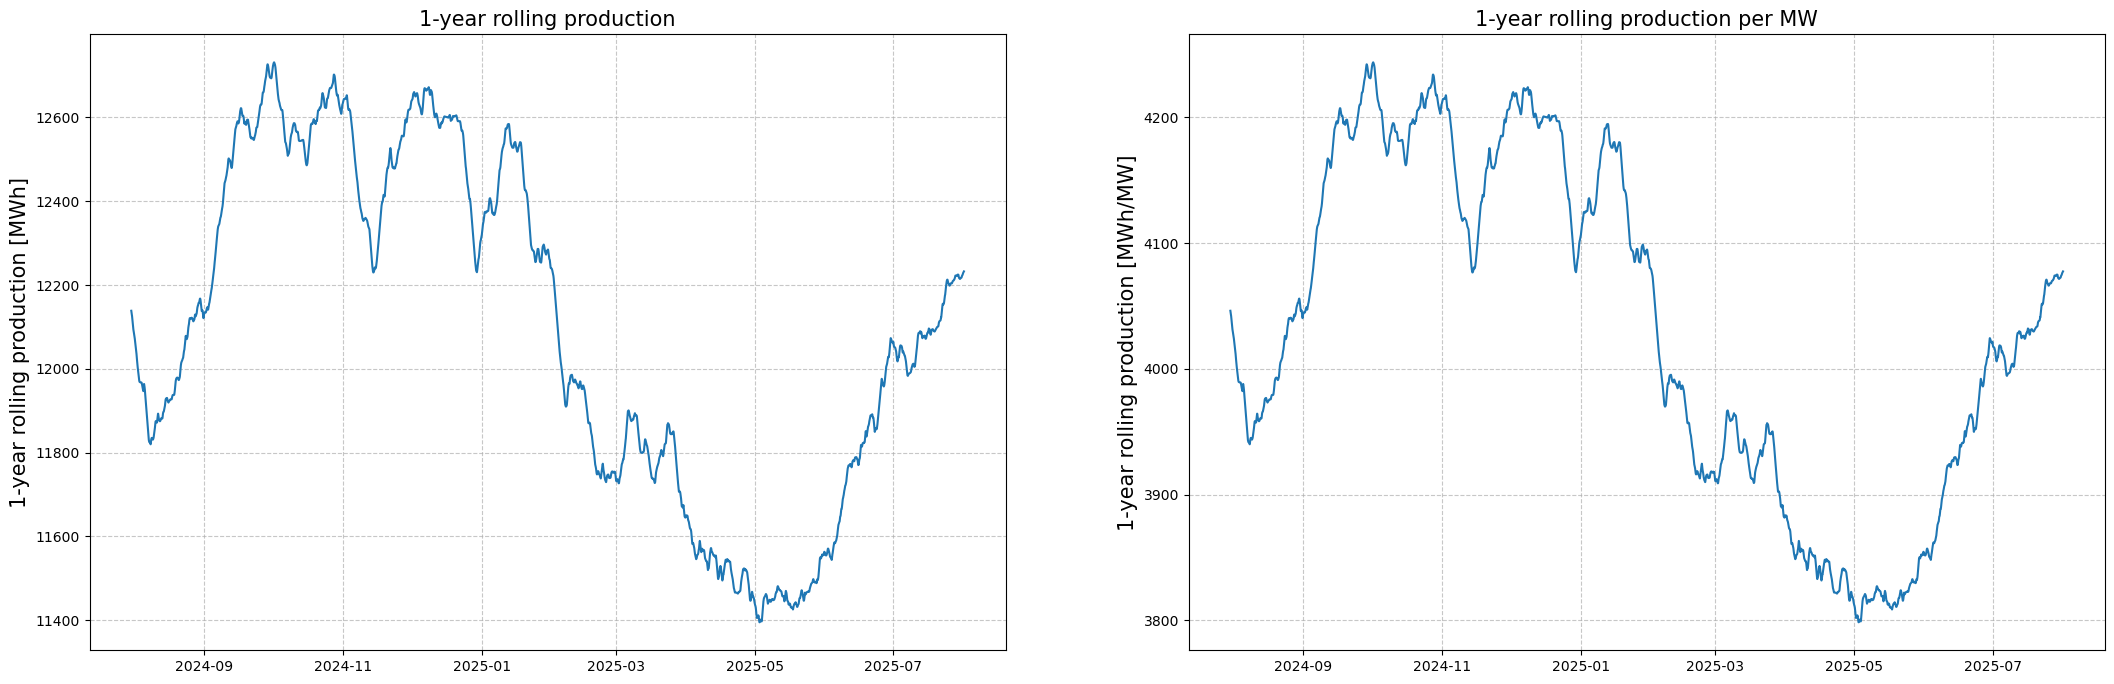

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(26, 8))

axes[0].plot(rolling_model_df)
axes[0].set_title('1-year rolling production', fontsize=15)
axes[0].set_ylabel('1-year rolling production [MWh]', fontsize=15)  # The data has hourly granularity, so average production value each hour is the same as power

axes[1].plot(rolling_model_df / (wind_turbine_type.nominal_power / 10**6))
axes[1].set_title('1-year rolling production per MW', fontsize=15)
axes[1].set_ylabel('1-year rolling production [MWh/MW]', fontsize=15)  # The data has hourly granularity, so average production value each hour is the same as power

for ax in axes.ravel():
    ax.grid(visible=True, alpha=0.7, linestyle='--')

plt.show()

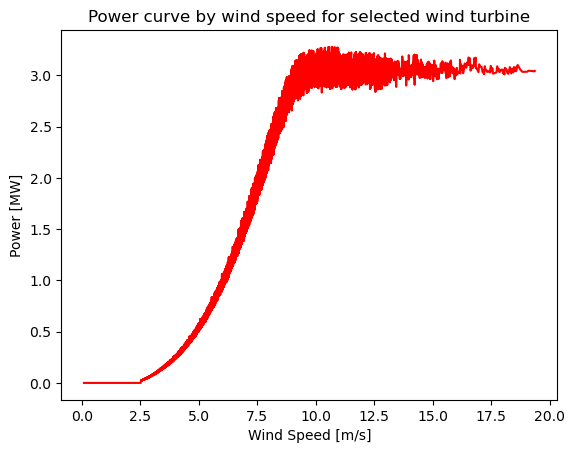

In [19]:
model_df_sorted = model_df.sort_values(by='wind speed', ignore_index=True, ascending=True)
plt.plot(model_df_sorted['wind speed'], model_df_sorted['Power [MW]'], c='r')
plt.xlabel('Wind Speed [m/s]')
plt.ylabel('Power [MW]')
plt.title('Power curve by wind speed for selected wind turbine')
plt.show()

Raw turbine model has been succesfully created. Average production achieved over 4 000 MWh/MW/year.

## 3.2. Correcting the model

According to the windpowerlib's documentation the turbine power output formula is:
$$
P = \frac{1}{8} \cdot \rho_{hub} \cdot d^{2}_{rotor} \cdot \pi \cdot v^{3}_{wind} \cdot cp(v_{wind})
$$

<img src="https://dr282zn36sxxg.cloudfront.net/datastreams/f-d%3A3f8fa52fa52e40e42a175010bf794074848b402bc72cf3d403afaf41%2BIMAGE_TINY%2BIMAGE_TINY.1"/><br>
To calculate the wind speed value which will participate in energy production the wind vector (i.e. velocity) needs to be split into X and Y components. The X component is the one which represents the wind's direction towards the turbine because its starting point is the same as the wind vector i.e. they "rotate" around the same axis (perpedicular to the image). As it is shown in the image, the formula for the X component is <b>wind speed multiplied by the cosine of the the angle between the wind speed direction and the X component (turbine-oriented vector)</b> which is the difference between degress of these 2 directions. Taking into account the cosine is an even function (symetric with respect to the y-axis i.e. cos(x) = cos(-x)), it does not matter how we substract these values by each other. The formula for the X component can be found below.<br>
$$
v_{x} = v_{0}\times cos(\Delta directions)
$$
It is important to the fact the cosine may be negative. Such case makes power output also negative which cannot happen. To prevent this the above formula has been corrected.
$$
v_{x} = v_{0}\times max(0, cos(\Delta directions))
$$
There is also another approach which focuses on correcting not the wind speed but the power output. Power corrected by yaw misalignment can be calculated using the formula:<br>
$$
P_{\gamma} = P_{0}\times cos^{\alpha}(\Delta directions)
$$
Among presented approaches <b>it has been decided to focus on correcting wind</b> instead of power. The reason behind this decision is the fact the wind is the source of the (kinetic) energy, so correcting this guarantees that any wind-dependant parameters and results will also be influenced (e.g. coefficient of power). If power was corrected, any parameters dependant on the wind speed during the power calculation would be unaffected, so the final results would be less reliable. <br>

Source:<br>
<a href="https://windpowerlib.readthedocs.io/en/stable/temp/windpowerlib.power_output.power_coefficient_curve.html">Turbine power output formula</a><br>
<a href="https://www.ck12.org/book/peoples-physics-concepts/section/3.1/">Image source</a><br>
<i>Analytical model for the power-yaw sensitivity of wind turbines operating in full wake</i>, Liew, Jaime Yikon; Urbán, Albert M.; Andersen, Søren Juhl, 2020

### 3.2.1. Turbine with fixed direction

The approach estimated in this section assumes wind turbine's rotor cannot rotate i.e. its direction is fixed. In such situation it cannot adjust to the wind direction. The goal of this section is to find the direction which will optimise the production for the available data.

Optimal fixed turbine direction is 252 degrees which is ~10762.814 MWh in the analysed 2-year period
------------------------------------------------------------------------------------------------------


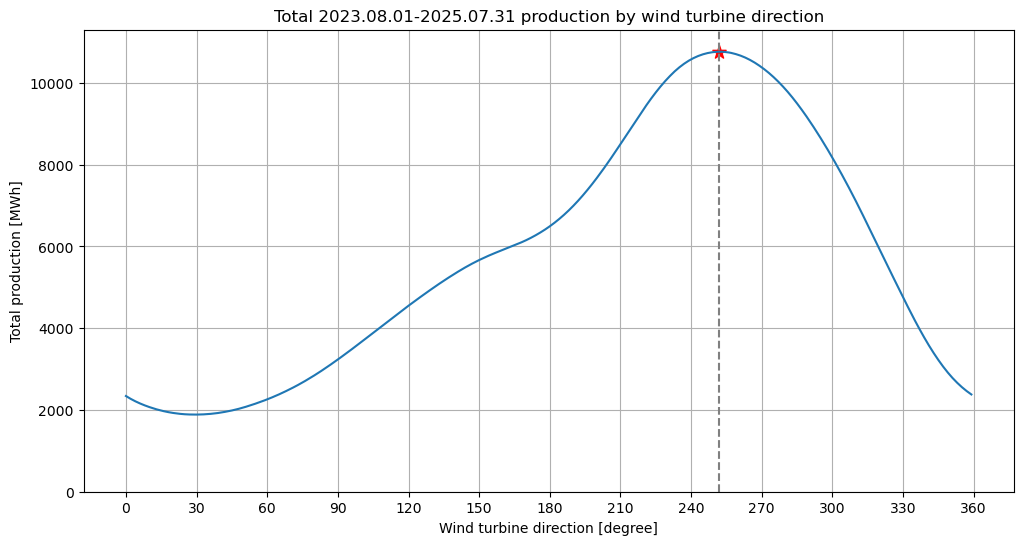

In [20]:
fixed_results = []

for n in np.arange(0, 360, 1):
    fixed_weather_df = final_weather_df.copy()
    fixed_weather_df[('wind_speed', 50)] = fixed_weather_df[('wind_speed', 50)] * np.maximum(0, np.cos((weather_df['WD50M']-n)*np.pi/180))
    fixed_turbine_model = ModelChain(wind_turbine_type, **turbine_sub_model).run_model(fixed_weather_df)

    fixed_turbine_power_output = fixed_turbine_model.power_output / 10**6 #Changing units from W to MW
    fixed_results.append( fixed_turbine_power_output.sum() )

fixed_results_df = pd.DataFrame(data={'Power [MW]': fixed_results}, index=np.arange(0, 360, 1))


fixed_turbine_direction = np.argmax(fixed_results_df) # Optimal turbine direction i.e. degree at which the highest volume is produced

print(f'Optimal fixed turbine direction is {fixed_turbine_direction} degrees which is ~{np.round(fixed_results[fixed_turbine_direction], 3)} MWh in the analysed 2-year period', 
     '------------------------------------------------------------------------------------------------------', sep='\n')

plt.figure(figsize=(12, 6))
plt.plot(fixed_results_df)
plt.xlabel('Wind turbine direction [degree]')
plt.ylabel('Total production [MWh]')  # The data has hourly granularity, so average production value each hour is the same as power
plt.title('Total 2023.08.01-2025.07.31 production by wind turbine direction')
plt.scatter(fixed_turbine_direction, fixed_results[fixed_turbine_direction], c='r', marker='*', s=100)
plt.vlines(x=fixed_turbine_direction, ymin=0, ymax=max(fixed_results)*1.05, linestyles='--', color='gray')
plt.xticks(range(0, 361, 30))
plt.ylim((0, max(fixed_results)*1.05))
plt.grid()
plt.show()

In [21]:
final_fixed_weather_df = final_weather_df.copy()
final_fixed_weather_df[('wind_speed', 50)] = final_fixed_weather_df[('wind_speed', 50)] * np.maximum(0, np.cos((weather_df['WD50M']-fixed_turbine_direction)*np.pi/180))
final_fixed_turbine_model = ModelChain(wind_turbine_type, **turbine_sub_model).run_model(final_fixed_weather_df)
(final_fixed_turbine_model.power_output / 10**6).sum()

10762.814283486263

In [22]:
print(
    f'Total 2-year production [MWh]: {(final_fixed_turbine_model.power_output / 10**6).sum()}',
    f'Average production [MWh/year]: {(final_fixed_turbine_model.power_output / 10**6).sum() /2}', 
    f'Average production [MWh/MW/year]: {(final_fixed_turbine_model.power_output / 10**6).sum() /2 / (wind_turbine_type.nominal_power / 10**6)}', 
    sep='\n'
)

Total 2-year production [MWh]: 10762.814283486263
Average production [MWh/year]: 5381.407141743131
Average production [MWh/MW/year]: 1793.8023805810437


Optimal fixed turbine direction is 252 degrees. Production results drops more than twice comparing to the base scenario.

### 3.2.2. Fully rotatable nacelle with fixed yaw misalignment angle

Modern wind turbines use to have a fully rotatable nacelle, so they can adjust the rotor position to maximise the usage of wind (i.e. be as perpendicular as possible to the wind vector). Despite such functionality, the rotor position is not perfect. According to the source, <i>"(...) over 50% of turbines operate with <b>more than 6° of static yaw misalignment</b> (...)"</i>. For the purpose of this analysis <b>10° (more than 6°) has been used</b>. <br>

<ul>This section presents:
    <li>the production volume by yaw misalignment degree</li>
    <li>the production volume for the selected yaw misalignment degree</li>
</ul>
Source:<br>
<a href="https://www.sereema.com/documents/yaw-misalignment-white-paper">Wind Turbine Yaw Misalignment: (R)Evolution</a>

Turbine cannot produce the energy for the <83; 277> yaw misalignment range in the analysed 2-year period
------------------------------------------------------------------------------------------------------


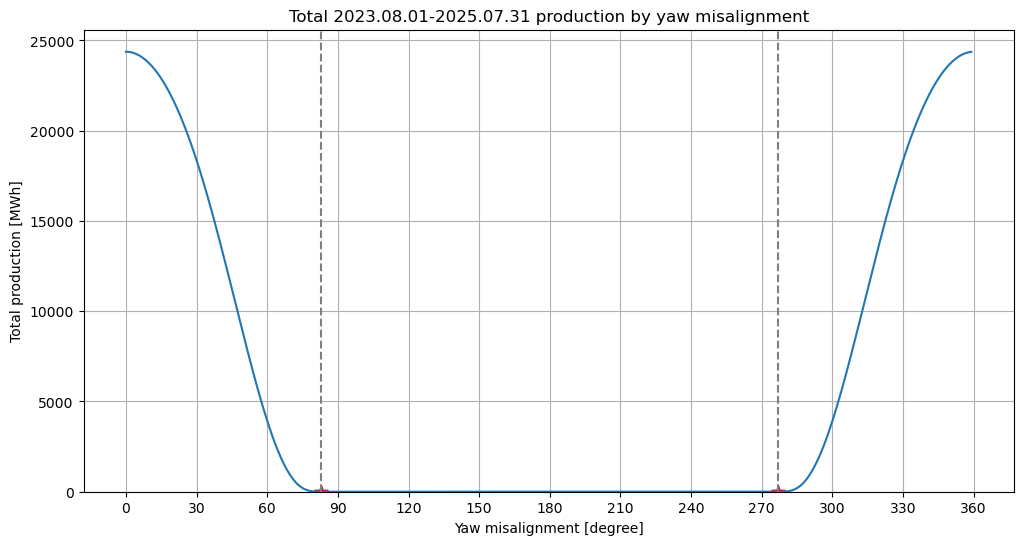

In [23]:
yaw_results = []
yaw_range = np.arange(0, 360, 1)
for n in yaw_range:
    yaw_weather_df = final_weather_df.copy()
    yaw_weather_df[('wind_speed', 50)] = yaw_weather_df[('wind_speed', 50)] * np.maximum(0, np.cos(n*np.pi/180))
    yaw_turbine_model = ModelChain(wind_turbine_type, **turbine_sub_model).run_model(yaw_weather_df)

    yaw_turbine_power_output = yaw_turbine_model.power_output / 10**6  # Changing units from W to MW
    
    yaw_results.append( yaw_turbine_power_output.sum() )

yaw_results_df = pd.DataFrame(data={'Power [MW]': yaw_results}, index=yaw_range)


yaw_turbine_min = np.argmin(yaw_results_df)  # The first turbine direction value for which the produced volume = 0

print(f'Turbine cannot produce the energy for the <{yaw_turbine_min}; {360-yaw_turbine_min}> yaw misalignment range in the analysed 2-year period', 
     '------------------------------------------------------------------------------------------------------', sep='\n')

plt.figure(figsize=(12, 6))
plt.plot(yaw_results_df)
plt.xlabel('Yaw misalignment [degree]')
plt.ylabel('Total production [MWh]')  # The data has hourly granularity, so average production value each hour is the same as power
plt.title('Total 2023.08.01-2025.07.31 production by yaw misalignment')
plt.scatter(yaw_turbine_min, yaw_results[yaw_turbine_min], c='r', marker='*', s=100)
plt.vlines(x=yaw_turbine_min, ymin=0, ymax=max(yaw_results)*1.05, linestyles='--', color='gray')
plt.scatter(360-yaw_turbine_min, yaw_results[yaw_turbine_min], c='r', marker='*', s=100)
plt.vlines(x=360-yaw_turbine_min, ymin=0, ymax=max(yaw_results)*1.05, linestyles='--', color='gray')
plt.xticks(range(0, 361, 30))
plt.ylim((0, max(yaw_results)*1.05))
plt.grid()
plt.show()

In [24]:
final_yaw_weather_df = final_weather_df.copy()
final_yaw_weather_df[('wind_speed', 50)] = final_yaw_weather_df[('wind_speed', 50)] * np.cos(10*np.pi/180)
final_yaw_turbine_model = ModelChain(wind_turbine_type, **turbine_sub_model).run_model(final_yaw_weather_df)
(final_yaw_turbine_model.power_output / 10**6).sum()

23714.013631602018

In [25]:
print(
    f'Total 2-year production [MWh]: {(final_yaw_turbine_model.power_output / 10**6).sum()}',
    f'Average production [MWh/year]: {(final_yaw_turbine_model.power_output / 10**6).sum() /2}', 
    f'Average production [MWh/MW/year]: {(final_yaw_turbine_model.power_output / 10**6).sum() /2 / (wind_turbine_type.nominal_power / 10**6)}', 
    sep='\n'
)

Total 2-year production [MWh]: 23714.013631602018
Average production [MWh/year]: 11857.006815801009
Average production [MWh/MW/year]: 3952.335605267003


Total and average production results are very close to the base scenario. It meets the expectations about low volume drop due to the fact that cos(10°) provides ~1,5% of wind speed loss.

# 4. Results analysis

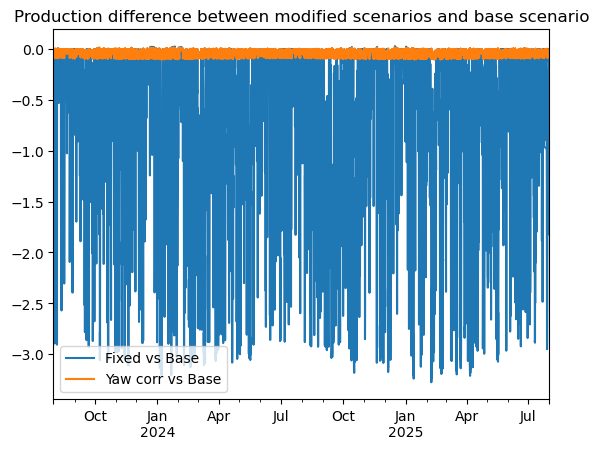

In [26]:
comparison_df = pd.concat([turbine_power_output, final_fixed_turbine_model.power_output / 10**6, final_yaw_turbine_model.power_output / 10**6], axis=1)
comparison_df.columns = ['Base scenario [MW]', 'Fixed position [MW]', 'Yaw misalignment correction [MW]']

cumsum_comparison_df = comparison_df.cumsum()
cumsum_comparison_df['Fixed vs Base'] = cumsum_comparison_df['Fixed position [MW]'] - cumsum_comparison_df['Base scenario [MW]']
cumsum_comparison_df['Yaw corr vs Base'] = cumsum_comparison_df['Yaw misalignment correction [MW]'] - cumsum_comparison_df['Base scenario [MW]']

comparison_df['Fixed vs Base'] = comparison_df['Fixed position [MW]'] - comparison_df['Base scenario [MW]']
comparison_df['Yaw corr vs Base'] = comparison_df['Yaw misalignment correction [MW]'] - comparison_df['Base scenario [MW]']

comparison_df[['Fixed vs Base', 'Yaw corr vs Base']].plot(title='Production difference between modified scenarios and base scenario');

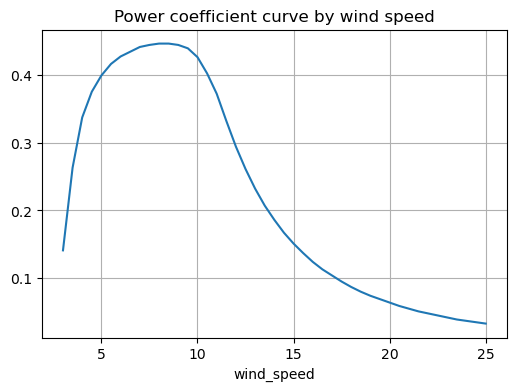

In [27]:
# checking power coefficient curve to identify for what wind speed range the coefficient decreases
wind_turbine_type.power_coefficient_curve.plot(
    x='wind_speed', y='value', grid=True, title='Power coefficient curve by wind speed', legend=False, figsize=(6, 4)
);

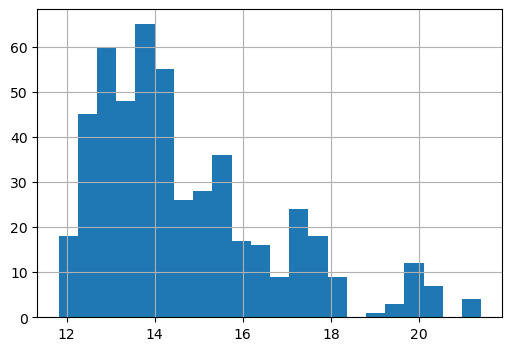

In [28]:
# checking wind speed for which the Fixed scenario was higher than the Base to compare with the above power coefficient curve.
fixed_wind_speed = final_fixed_turbine_model.wind_speed_hub(final_fixed_weather_df)
fixed_wind_speed[comparison_df['Fixed vs Base'] > 0].hist(
    bins=int(np.floor(len(comparison_df[comparison_df['Fixed vs Base'] > 0])**0.5)), figsize=(6, 4)
);

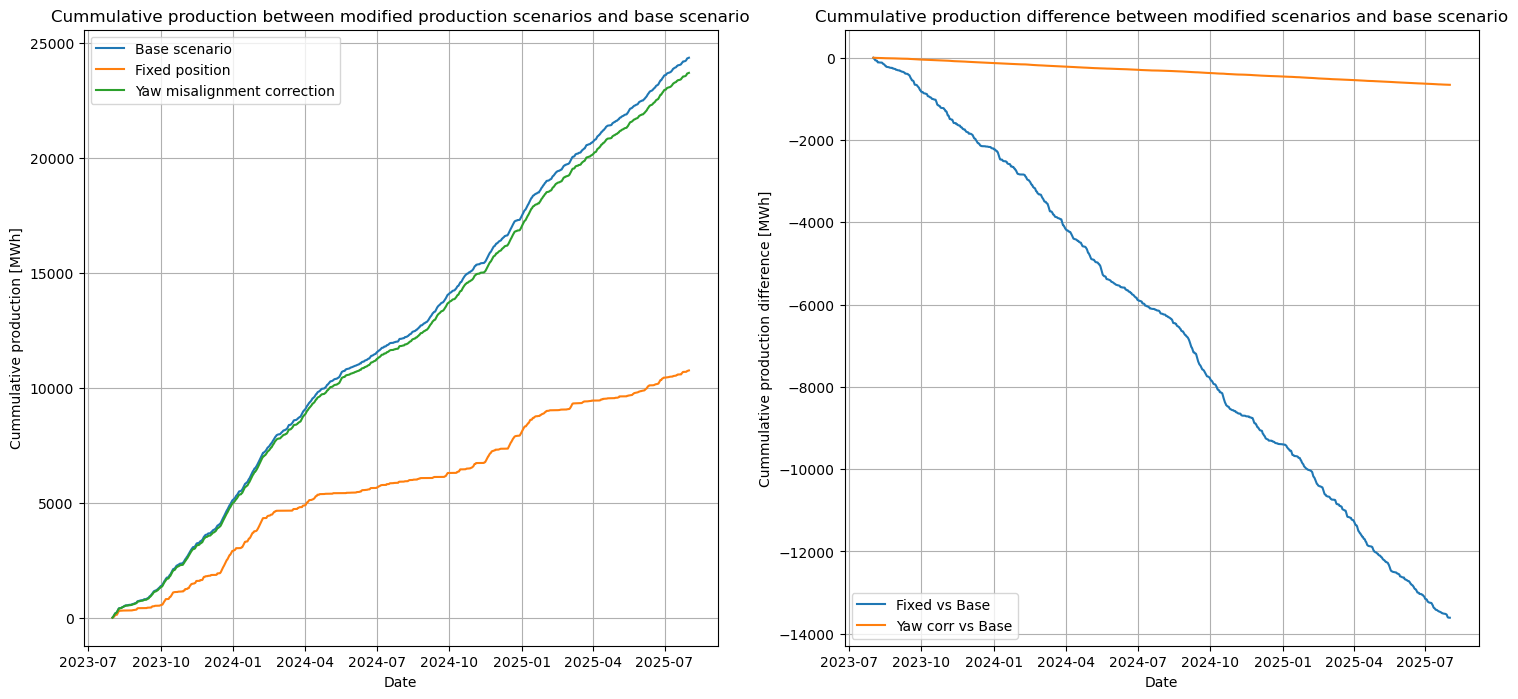

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8), sharex=True)

axes[0].plot(cumsum_comparison_df[['Base scenario [MW]', 'Fixed position [MW]', 'Yaw misalignment correction [MW]']])
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Cummulative production [MWh]')
axes[0].set_title('Cummulative production between modified production scenarios and base scenario')
axes[0].grid()
axes[0].legend(labels=['Base scenario', 'Fixed position', 'Yaw misalignment correction'])

axes[1].plot(cumsum_comparison_df[['Fixed vs Base', 'Yaw corr vs Base']])
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cummulative production difference [MWh]')
axes[1].set_title('Cummulative production difference between modified scenarios and base scenario')
axes[1].grid()
axes[1].legend(labels=['Fixed vs Base', 'Yaw corr vs Base'])

plt.show()

In [30]:
comparison_df.sum()

Base scenario [MW]                  24372.405372
Fixed position [MW]                 10762.814283
Yaw misalignment correction [MW]    23714.013632
Fixed vs Base                      -13609.591088
Yaw corr vs Base                     -658.391740
dtype: float64

<b>Fixed position</b> scenario stands out strongly comparing to the remaining scenarios. Fixed position's production was higher than the base scenario's in a few hundred hours. At the first glance it may be illogical taking into account the wind speed is multiplied by max(0, cos) i.e. it is usually multiplied by a fraction. However, using the power coefficient curve and histogram for the positive 'Fixed vs Base' values it can be seen this fixed scenario's advantage is when the power coefficient decreases with an increase of the wind speed. In other words, max(0, cos) lowers the wind speed which causes the power coefficient value increase what in total helps generate more power than the base scenario in some cases.<br>
<b>Yaw misalignment correction</b> scenario does not differ much from the base one but, as it was mentioned before, it is important to take into account that cos(10) provides ~1,5% of wind loss, so the low difference from the base scenario could have been expected.

# 5. Saving final dataset

The yaw misalignment correction scenario has been chosen as the final result because it is the most balanced among analysed 3 scenarios. Fixed position scenario is too conservative while base scenario is too optimistic.

In [31]:
yaw_wind_speed = final_yaw_turbine_model.wind_speed_hub(final_yaw_weather_df)

to_save = weather_df.copy()
to_save['Wind speed at 100 m [m/s]'] = yaw_wind_speed
to_save['Turbine nominal power [MW]'] = wind_turbine_type.nominal_power / 10**6
to_save['Power [MW]'] = final_yaw_turbine_model.power_output / 10**6

to_save.to_csv('yaw_model_dataset.csv')

# 6. Ideas of extending the analysis

<ul>
    <li>Using different data source e.g. <a href="https://danepubliczne.imgw.pl/">IMGW</a></li>
    <li>Using other models to estimate wind speed, temperature and pressure for the selected height</li>
    <li>Testing other wind turbine</li>
    <li>Testing other hub height or using hub height as a variable and check the power sensitivity by the height</li>
    <li>Taking into account that turbine does not immediately rotate towards the wind i.e. assuming a rotation speed and calculating the production including duration of the rotation process</li>
</ul>